# Statistical arbitrage with graph clustering algorithms

# Paper: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4560455

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings

In [2]:
%config InlineBackend.figure_format = 'retina'
sns.set_style('darkgrid')

In [3]:
num_periods = 252

def calculate_metrics(cumret, num_periods=num_periods):
    '''
    calculate performance metrics from cumulative returns
    
    cumret: cumulative returns
    num_periods: number of periods in a year (e.g. 252 if cumret is at daily resolution)
    '''
    total_return = (cumret[-1] - cumret[0])/cumret[0]
    apr = (1+total_return)**(num_periods/len(cumret)) - 1
    rets = pd.DataFrame(cumret).pct_change()
    rets.iloc[0] = 0
    sharpe = np.sqrt(num_periods) * np.nanmean(rets) / np.nanstd(rets)
    sortino = np.sqrt(num_periods) * np.nanmean(rets) / np.nanstd(rets[rets<0])
    
    # maxdd and maxddd
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=cumret[t]/highwatermark[t]-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
    maxDD=np.min(drawdown)
    maxDDD=np.max(drawdownduration)
    
    return total_return, apr, sharpe, sortino, maxDD, maxDDD

# Prepare data

In [4]:
prices = pd.read_csv('../sp500.csv', index_col=0)
prices.index = pd.to_datetime(prices.index)

In [5]:
returns = prices.pct_change().iloc[1:]

#### Factor data

In [6]:
ff_data = pd.read_csv('../F-F_Research_Data_Factors_daily.CSV', skiprows=3, index_col=0).iloc[:-1]
ff_data.index = pd.to_datetime(ff_data.index)
ff_data = ff_data.loc[returns.index]
ff_data /= 100 # percent to decimal

In [7]:
ff_data

,Mkt-RF,SMB,HML,RF
Date,,,,
2018-01-03,0.0059,-0.0039,-0.0018,0.00006
2018-01-04,0.0042,-0.0026,0.0024,0.00006
2018-01-05,0.0066,-0.0035,-0.0026,0.00006
2018-01-08,0.0019,-0.0015,0.0005,0.00006
2018-01-09,0.0015,-0.0035,-0.0004,0.00006
...,...,...,...,...
2022-12-23,0.0051,-0.0061,0.0116,0.00016
2022-12-27,-0.0051,-0.0074,0.0142,0.00016
2022-12-28,-0.0123,-0.0024,-0.0029,0.00016


# Calculate residuals

In [8]:
from sklearn.linear_model import LinearRegression

In [9]:
# estimate betas
returns_rf = returns - ff_data[['RF']].values
res = LinearRegression().fit(ff_data[['Mkt-RF']].values, returns_rf.values)
betas = pd.Series(res.coef_.flatten(), index=returns.columns)

In [10]:
betas

MMM     0.785349
AOS     0.829262
ABT     0.828250
ABBV    0.645919
ACN     1.058302
          ...   
YUM     0.760548
ZBRA    1.282428
ZBH     0.898467
ZION    1.047937
ZTS     0.910777
Length: 490, dtype: float64

In [11]:
# calculate residuals
resid = pd.DataFrame(index=returns.index, columns=returns.columns)
for s in tqdm(returns.columns):
    resid[s] = returns_rf[s] - betas.loc[s] * ff_data['Mkt-RF']

100%|██████████| 490/490 [00:00<00:00, 1468.08it/s]


In [12]:
resid

,MMM,AOS,ABT,ABBV,ACN,ADM,ADBE,ADP,AES,AFL,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-03,-0.004736,0.001061,-0.002735,0.011778,-0.001689,-0.012383,0.011274,0.004918,-0.006992,-0.002627,...,0.013903,-0.011552,-0.019517,-0.009984,0.005906,-0.005405,0.012237,0.001571,-0.007426,-0.000835
2018-01-04,0.009713,0.001142,-0.005236,-0.008475,0.007336,0.013515,0.006670,0.005303,-0.008020,0.006322,...,0.006713,0.004042,-0.000784,-0.010151,0.002184,0.006926,0.014314,-0.005275,-0.000314,0.002078
2018-01-05,0.002548,0.007331,-0.002636,0.013085,0.001204,-0.011869,0.003164,-0.007235,-0.003093,0.000381,...,0.001044,0.003386,-0.003035,-0.010677,-0.008900,0.000748,0.007052,0.003951,-0.006583,0.005373
2018-01-08,-0.004794,0.003127,-0.004516,-0.017309,0.005921,-0.003778,-0.004082,-0.004999,-0.001996,0.000724,...,-0.006975,-0.001739,-0.016151,0.006380,0.001545,0.000185,0.007454,0.000138,-0.006966,0.010205
2018-01-09,0.004976,-0.002094,0.000398,0.006510,0.001687,0.002016,0.007014,0.005396,-0.011708,-0.001019,...,0.001508,-0.005415,0.004525,-0.012548,-0.001355,-0.003852,0.028659,-0.017491,0.021877,0.010293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,-0.016091,0.007526,-0.002996,-0.004495,-0.000534,0.007959,-0.000875,0.002195,0.007712,0.006912,...,0.004364,0.001978,-0.014014,0.009899,-0.006271,-0.003418,-0.003832,-0.003636,-0.001983,0.000229
2022-12-27,0.004511,0.017602,0.007669,0.002460,0.002306,0.017441,-0.003638,0.005301,0.009919,0.011444,...,0.004720,0.004753,0.052016,0.011656,0.014245,0.011477,0.017580,0.009079,0.013234,0.001329
2022-12-28,-0.006554,-0.005566,0.003212,0.003122,0.004603,-0.014468,-0.004778,-0.001084,-0.004974,0.000695,...,-0.001878,-0.003921,-0.032462,-0.000628,-0.003254,0.004653,-0.000960,0.000756,-0.005084,0.000925


# Choosing the number of clusters

In [13]:
corr = resid.corr() # correlation matrix
evalues = np.linalg.eigh(corr)[0] # eigenvalues

#### RMT approach

In [14]:
Q = returns.shape[0] / returns.shape[1]
Q

2.5673469387755103

In [15]:
lambda_plus = 1 + 1/Q + 2 * np.sqrt(1/Q)
lambda_plus

2.6377173195506476

In [16]:
# number of clusters
len(evalues[evalues>lambda_plus])

25

#### Explained variance approach

In [17]:
P = 0.9 # min. percentage of variance to explain

In [18]:
explained_variance = (sorted(evalues)[::-1] / evalues.sum()).cumsum()

In [19]:
# number of clusters
np.where(explained_variance>P)[0][0]

233

# Clustering techniques

### 2.1.1 Spectral Clustering

In [66]:
from signet.cluster import Cluster
from scipy.sparse import csc_matrix

In [67]:
c = Cluster((csc_matrix(abs(corr)), csc_matrix(np.zeros(corr.shape))))

In [68]:
c.spectral_cluster_adjacency(k=25)

/home/alex/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([ 5,  5, 10, 15, 10,  2,  2, 18, 17, 17, 11, 18, 17,  9,  0, 24, 11,
        5, 12,  2,  2,  2,  2,  2,  1,  2, 12,  9, 12, 22, 22, 12, 12, 22,
        5, 15,  0,  8,  2, 18,  6, 17,  8,  9,  2,  1, 18,  2,  2, 12,  2,
       16, 24,  5, 15,  6, 10, 22,  4, 15, 15,  2,  2, 20, 11, 21,  0,  5,
        0, 22,  9,  9,  4, 17,  1, 15,  8, 10, 18,  3,  2, 19,  2,  9, 24,
        3, 22, 15, 17,  9, 21,  4, 18, 17,  0,  4, 15, 14,  7,  6, 11, 22,
        0,  6, 15,  2,  3, 14,  2,  1, 23, 22, 22,  3, 18, 12,  7,  1,  3,
       15, 22,  3,  6, 12,  1, 11, 21,  5, 21,  9, 21, 12,  5,  5, 15, 20,
       11, 17, 15,  4,  9, 17,  6, 21,  6, 10, 22,  9, 16, 16, 12, 21,  5,
        7, 12,  4,  4,  5,  1,  1,  7, 11,  4, 14, 15,  4, 15, 12,  6, 21,
       21, 10, 10, 24, 24,  0,  2,  2, 12, 12, 12,  9, 19, 24,  6, 23, 10,
       21, 19, 17, 19, 22, 15, 12, 13, 13, 17,  4,  4,  2,  5,  4,  4,  0,
        0,  0, 15,  2,  4,  3,  4,  5, 15,  2, 13, 22,  6, 17,  0, 17, 24,
        2,  7,  6,  4,  9

In [69]:
c.spectral_cluster_adjacency(k=25)[:100]

/home/alex/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([13, 13, 23,  5,  7,  4,  4, 24, 20,  6, 23, 24, 17, 17,  1, 14, 23,
       13, 15,  6,  6,  6,  8,  6,  6,  6, 15, 17, 15,  0,  0, 14, 15,  0,
       13,  5,  1, 12,  4, 24, 11,  6, 12, 17,  6, 21, 24,  6,  8, 15,  8,
       10,  2, 13,  8, 11,  7,  0, 22,  5,  5,  6,  4,  9, 23,  8,  1, 13,
        1,  0, 17, 17, 22, 20,  3,  5, 12,  7, 24, 19,  4, 18,  4, 17,  2,
       19,  0, 16,  1, 17,  8, 22, 24, 22,  1, 22, 16, 16,  2, 11],
      dtype=int32)

### 2.1.2 Signed Laplacing Clustering

In [23]:
# split adjacency matrix into positive and negative
corr_positive = pd.DataFrame(index=corr.index, columns=corr.columns)
corr_negative = pd.DataFrame(index=corr.index, columns=corr.columns)

corr_positive[corr>0] = corr[corr>0]
corr_positive = corr_positive.fillna(0)
corr_negative[corr<0] = -corr[corr<0]
corr_negative = corr_negative.fillna(0)

In [24]:
c = Cluster((csc_matrix(corr_positive), csc_matrix(corr_negative)))

In [65]:
c = Cluster((corr_positive, corr_negative))

AttributeError: 'DataFrame' object has no attribute 'tocsc'

In [25]:
c.spectral_cluster_laplacian(k=25)

/home/alex/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([ 5, 12, 10, 10, 23,  5,  4, 23, 11, 11, 19,  5,  5, 21, 12,  2, 16,
        1,  2,  5,  8,  8,  5,  4, 11,  6,  2, 17,  2, 21, 13,  2,  2, 13,
        1, 10, 12,  6, 16, 23,  0, 24,  6, 17, 11, 12, 23, 11,  5,  2,  4,
        1,  2,  1, 20,  0,  2, 13,  3, 10, 10,  5,  5,  1, 19, 16, 10,  1,
        3, 13, 21, 17, 12, 11,  9, 10,  6, 23, 23,  2, 11,  5, 16, 17,  2,
       14, 21,  5, 21, 17, 16, 12, 23,  3,  3, 12, 10, 22,  2,  0, 16, 13,
       23,  0, 17,  5, 14, 22,  5, 11, 10, 13, 13, 14, 23,  2,  2,  1, 14,
        5, 13, 14,  0,  2, 11,  9,  3, 12, 16, 14,  5,  2,  1, 12,  5,  3,
       19,  3,  5, 12, 17, 11,  0, 20,  0,  2, 21, 21, 14,  1,  2,  1,  1,
        2,  2, 12, 12,  1,  1, 23,  2,  9, 18, 22, 10, 12, 15,  2,  0, 16,
        0, 23,  2,  2,  2,  3, 21,  5,  2,  2,  2, 17,  1,  2,  0, 12, 23,
        9,  1, 11, 12, 13, 15,  2,  9,  9, 21, 11, 21, 20, 11, 13,  0,  1,
        3,  7, 16,  5, 13, 14, 17,  1, 10,  5,  9, 13,  0, 11, 21, 11,  2,
        5,  2,  0, 12, 17

### 2.1.3 SPONGE - generalized eigenproblem clustering (SPONGE_sym)

In [26]:
c = Cluster((csc_matrix(corr_positive), csc_matrix(corr_negative)))

In [27]:
c.SPONGE_sym(k=25)[:100]

/home/alex/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([ 1, 13,  2, 19, 18,  1,  8, 18,  5, 16,  2, 13,  9,  5, 13,  3,  2,
        1,  3, 16,  6,  6, 14, 24, 13,  8,  3,  5,  3, 16, 16,  3,  3, 16,
        1, 19, 13,  4,  8, 22, 12, 17,  4,  5, 16, 15, 22, 16, 19,  3,  8,
       11,  3,  1,  8, 12,  3, 16,  5,  9,  2, 16, 16, 21,  2,  2, 20, 16,
       21, 16,  5,  5,  1,  5,  9, 19,  4, 18, 22, 14,  1, 13,  8,  5,  3,
       14, 16, 19, 21,  5,  2,  1, 18,  1,  1,  1, 19, 11,  3, 12],
      dtype=int32)

# Strategies

### Baseline (no clustering)

In [28]:
start_date = '2019-01-01'
end_date = '2022-12-31'

In [29]:
# subtract risk-free rate from returns
returns_rf = returns - ff_data[['RF']].values

In [30]:
# calculate positions
positions = pd.DataFrame(index=returns_rf.loc[start_date:end_date].index, columns=returns_rf.columns)
positions[returns_rf < ff_data[['Mkt-RF']].values] = 1
positions[returns_rf > ff_data[['Mkt-RF']].values] = -1

# make absolute values of long and short positions sum to 1
positions[positions>0] *= 1/abs(positions[positions>0].sum(axis=1)).values.reshape(-1,1)
positions[positions<0] *= 1/abs(positions[positions<0].sum(axis=1)).values.reshape(-1,1)

In [31]:
positions

,MMM,AOS,ABT,ABBV,ACN,ADM,ADBE,ADP,AES,AFL,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,0.003226,-0.005556,0.003226,0.003226,0.003226,0.003226,0.003226,0.003226,0.003226,0.003226,...,0.003226,0.003226,-0.005556,0.003226,0.003226,0.003226,0.003226,0.003226,-0.005556,0.003226
2019-01-03,0.005208,-0.003356,0.005208,0.005208,0.005208,-0.003356,0.005208,0.005208,-0.003356,0.005208,...,-0.003356,0.005208,-0.003356,-0.003356,0.005208,0.005208,0.005208,-0.003356,-0.003356,0.005208
2019-01-04,-0.004608,-0.004608,0.003663,0.003663,-0.004608,0.003663,-0.004608,-0.004608,0.003663,0.003663,...,0.003663,-0.004608,-0.004608,0.003663,-0.004608,0.003663,-0.004608,0.003663,0.003663,-0.004608
2019-01-07,0.003584,-0.004739,-0.004739,-0.004739,0.003584,0.003584,-0.004739,0.003584,0.003584,0.003584,...,0.003584,0.003584,-0.004739,0.003584,0.003584,0.003584,-0.004739,0.003584,0.003584,0.003584
2019-01-08,0.004274,-0.003906,0.004274,0.004274,-0.003906,-0.003906,-0.003906,0.004274,-0.003906,0.004274,...,0.004274,0.004274,-0.003906,-0.003906,0.004274,0.004274,0.004274,0.004274,0.004274,-0.003906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,0.004386,-0.003817,0.004386,0.004386,0.004386,-0.003817,-0.003817,-0.003817,-0.003817,-0.003817,...,-0.003817,-0.003817,0.004386,-0.003817,0.004386,0.004386,0.004386,0.004386,0.004386,0.004386
2022-12-27,-0.002591,-0.002591,-0.002591,-0.002591,-0.002591,-0.002591,0.009615,-0.002591,-0.002591,-0.002591,...,-0.002591,-0.002591,-0.002591,-0.002591,-0.002591,-0.002591,-0.002591,-0.002591,-0.002591,-0.002591
2022-12-28,0.003817,0.003817,-0.004386,-0.004386,-0.004386,0.003817,0.003817,0.003817,0.003817,-0.004386,...,-0.004386,0.003817,0.003817,-0.004386,0.003817,-0.004386,0.003817,-0.004386,0.003817,-0.004386


In [32]:
# calculate strategy returns
ret = (positions.shift() * returns.loc[positions.index]).sum(axis=1)
cumret_baseline = (1 + ret).cumprod()

In [33]:
# calculate market returns
ret_market = (ff_data['Mkt-RF'] + ff_data['RF']).loc[positions.index]
cumret_market = (1 + ret_market).cumprod()

In [34]:
results_df = pd.DataFrame(columns=['Total return', 'APR', 'Sharpe', 'Sortino', 'MaxDD', 'MaxDDD'])
results_df.loc['Market'] = calculate_metrics(cumret_market)
results_df.loc['Algo Baseline'] = calculate_metrics(cumret_baseline)

In [35]:
results_df

,Total return,APR,Sharpe,Sortino,MaxDD,MaxDDD
Market,0.591039,0.123105,0.613394,0.742505,-0.342550,282.0
Algo Baseline,0.202382,0.047154,0.438280,0.572653,-0.236759,408.0


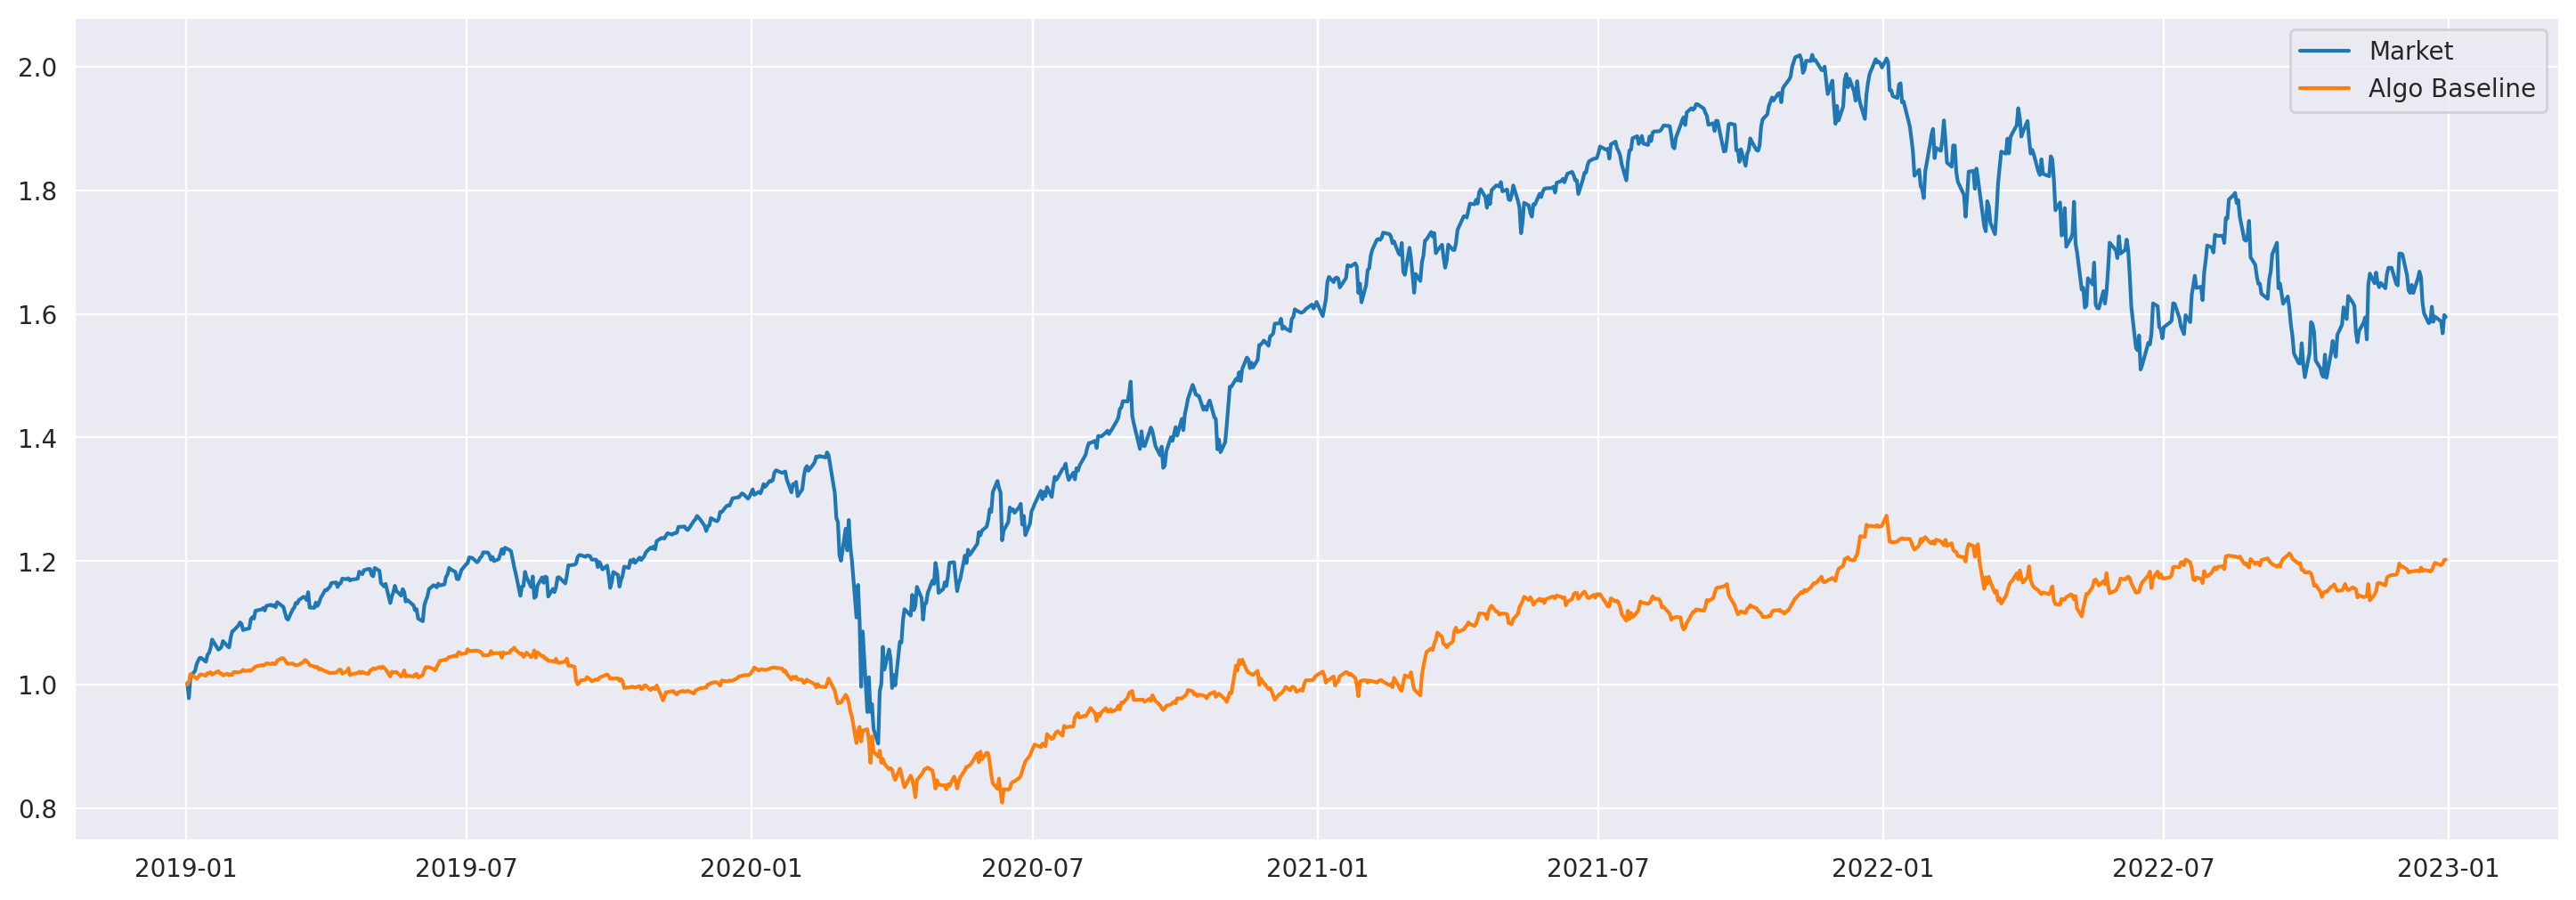

In [36]:
plt.figure(figsize=(18,6))
plt.plot(cumret_market, label='Market')
plt.plot(cumret_baseline, label='Algo Baseline')
plt.legend()

### Spectral clustering

In [37]:
w = 60 # length of the rolling window

In [38]:
def spectral_clustering_bt(t):
    # prepare data
    returns_rf_tmp = returns_rf.loc[:t].iloc[-w:]
    returns_rf_tmp = returns_rf_tmp.dropna(axis=1)
    ff_data_tmp = ff_data.loc[returns_rf_tmp.index]

    # compute betas
    res = LinearRegression().fit(ff_data_tmp[['Mkt-RF']].values, returns_rf_tmp.values)
    betas = pd.Series(res.coef_.flatten(), index=returns_rf_tmp.columns)

    # compute residuals
    resid = pd.DataFrame(index=returns_rf_tmp.index, columns=returns_rf_tmp.columns)
    for s in resid.columns:
        resid[s] = returns_rf_tmp[s] - betas.loc[s] * ff_data_tmp['Mkt-RF']

    # estimate the number of clusters
    corr = resid.corr() # correlation matrix
    evalues = np.linalg.eigh(corr)[0]
    Q = returns_rf_tmp.shape[0] / returns_rf_tmp.shape[1]
    lambda_plus = 1 + 1/Q + 2*np.sqrt(1/Q) # upper RMT bound
    K = len(evalues[evalues>lambda_plus]) # number of clusters

    # perform clustering
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        c = Cluster((csc_matrix(abs(corr)), csc_matrix(np.zeros(corr.shape)))) # use absolute values of correlation matrix as input
        ca = c.spectral_cluster_adjacency(k=K)

    # construct positions
    positions = pd.DataFrame(index=[t], columns=returns_rf.columns)
    positions = positions.fillna(0)
    for cluster in range(K):
        c_members = returns_rf_tmp.columns[ca==cluster]
        c_winners = returns_rf_tmp[c_members].mean()[returns_rf_tmp[c_members].mean()>returns_rf_tmp[c_members].mean().mean()].index
        c_losers = returns_rf_tmp[c_members].mean()[returns_rf_tmp[c_members].mean()<returns_rf_tmp[c_members].mean().mean()].index
        positions.loc[t, c_winners] = -1 / len(c_winners) # short position in winners
        positions.loc[t, c_losers] = 1 / len(c_losers) # long_position in losers

    return positions

In [39]:
positions = pd.concat([spectral_clustering_bt(t) for t in returns_rf.loc[start_date:end_date].index])

In [40]:
# make absolute values of long and short positions sum to 1
positions[positions>0] *= 1/abs(positions[positions>0].sum(axis=1)).values.reshape(-1,1)
positions[positions<0] *= 1/abs(positions[positions<0].sum(axis=1)).values.reshape(-1,1)

In [41]:
# calculate strategy returns
ret = (positions.shift() * returns.loc[positions.index]).sum(axis=1)
cumret_spectral = (1 + ret).cumprod()

In [42]:
results_df.loc['Algo Spectral'] = calculate_metrics(cumret_spectral)

In [43]:
results_df

,Total return,APR,Sharpe,Sortino,MaxDD,MaxDDD
Market,0.591039,0.123105,0.613394,0.742505,-0.342550,282.0
Algo Baseline,0.202382,0.047154,0.438280,0.572653,-0.236759,408.0
Algo Spectral,0.298239,0.067428,0.596622,0.878711,-0.213737,271.0


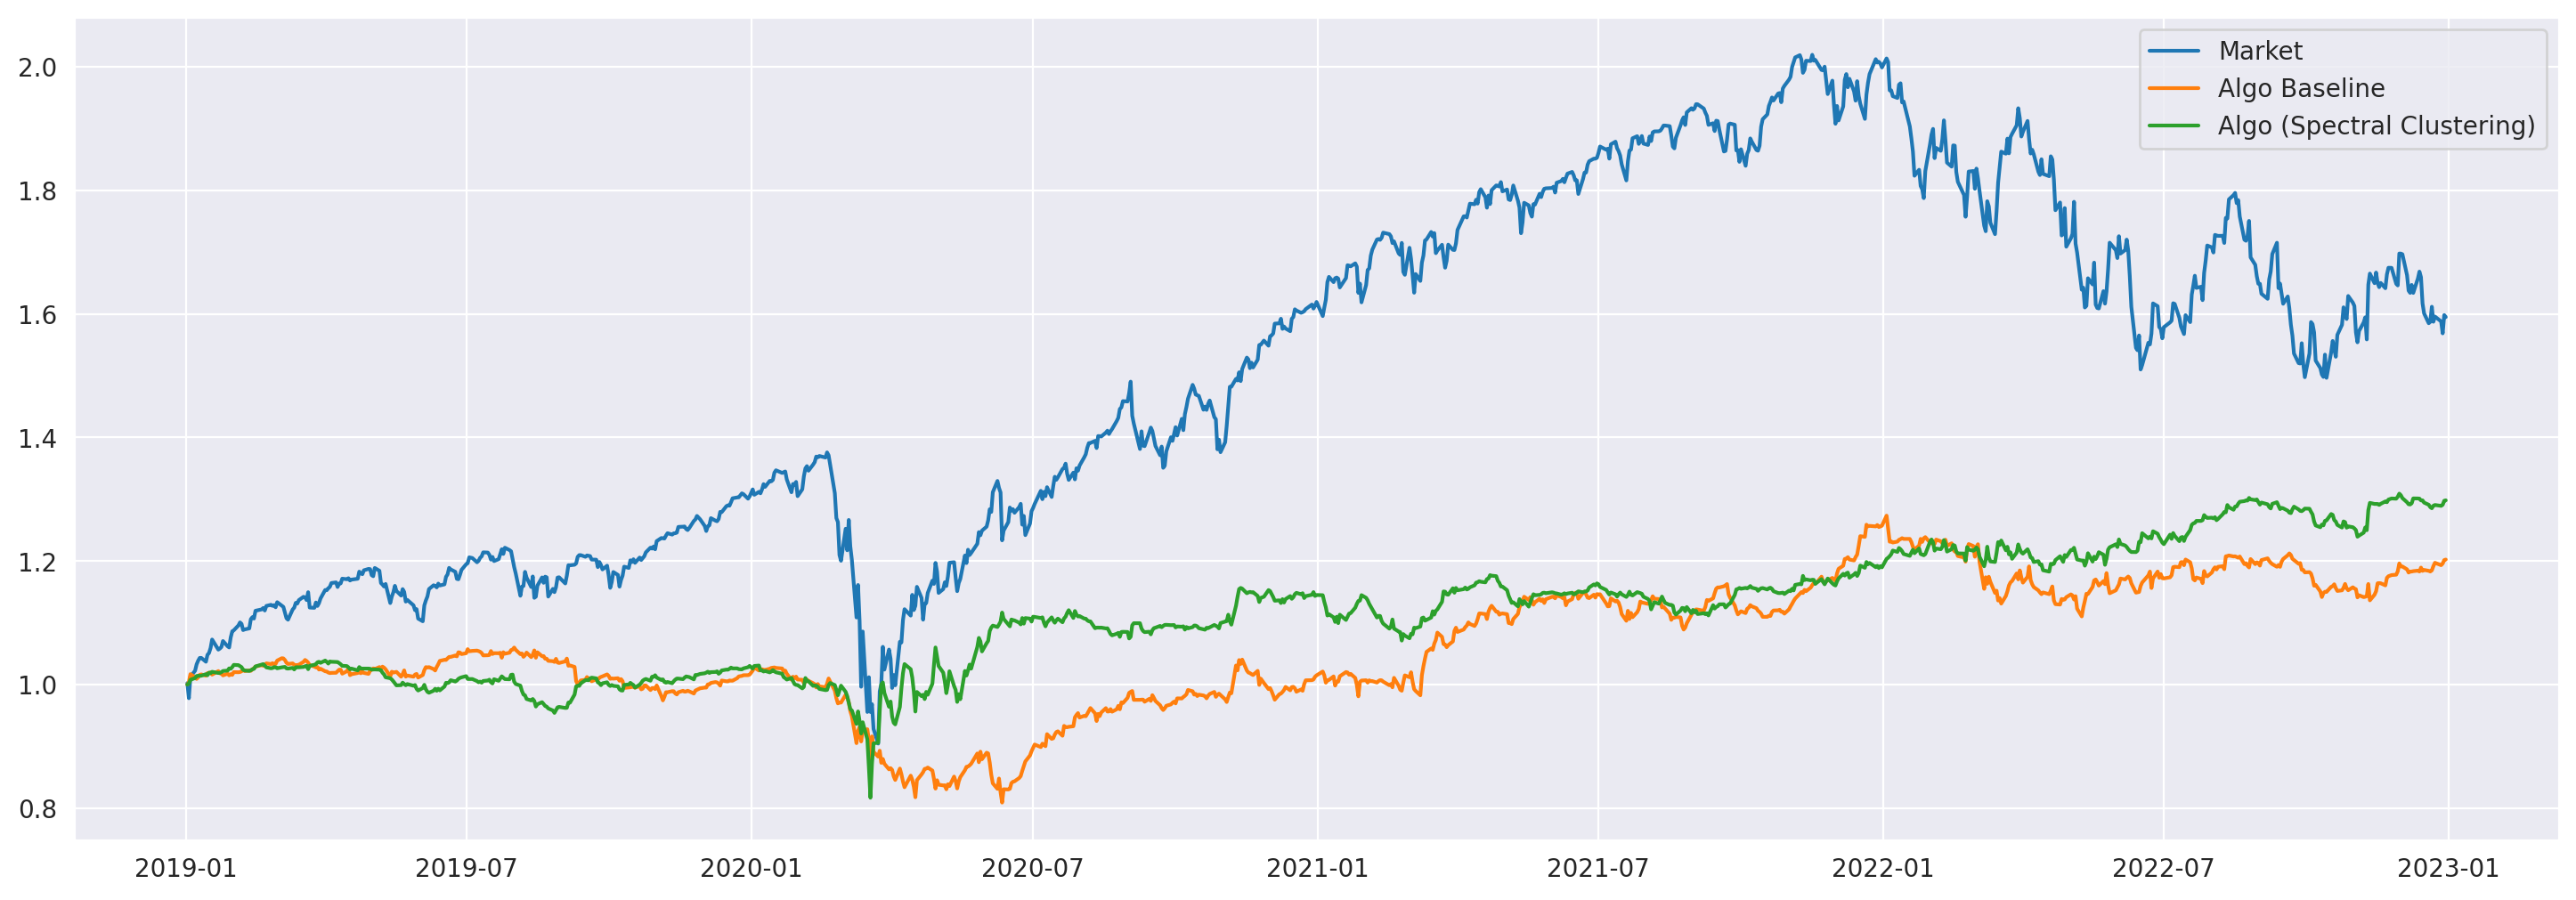

In [44]:
plt.figure(figsize=(18,6))
plt.plot(cumret_market, label='Market')
plt.plot(cumret_baseline, label='Algo Baseline')
plt.plot(cumret_spectral, label='Algo (Spectral Clustering)')
plt.legend()

In [45]:
np.corrcoef(ret,ret_market)

array([[1.  , 0.29],
       [0.29, 1.  ]])

### Signed Laplacian Clustering

In [46]:
def signed_laplacian_clustering_bt(t):
    # prepare data
    returns_rf_tmp = returns_rf.loc[:t].iloc[-w:]
    returns_rf_tmp = returns_rf_tmp.dropna(axis=1)
    ff_data_tmp = ff_data.loc[returns_rf_tmp.index]

    # compute betas
    res = LinearRegression().fit(ff_data_tmp[['Mkt-RF']].values, returns_rf_tmp.values)
    betas = pd.Series(res.coef_.flatten(), index=returns_rf_tmp.columns)

    # compute residuals
    resid = pd.DataFrame(index=returns_rf_tmp.index, columns=returns_rf_tmp.columns)
    for s in resid.columns:
        resid[s] = returns_rf_tmp[s] - betas.loc[s] * ff_data_tmp['Mkt-RF']

    # estimate the number of clusters
    corr = resid.corr() # correlation matrix
    evalues = np.linalg.eigh(corr)[0]
    Q = returns_rf_tmp.shape[0] / returns_rf_tmp.shape[1]
    lambda_plus = 1 + 1/Q + 2*np.sqrt(1/Q) # upper RMT bound
    K = len(evalues[evalues>lambda_plus]) # number of clusters

    # perform clustering
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        # split adjacency matrix into positive and negative
        corr_positive = pd.DataFrame(index=corr.index, columns=corr.columns)
        corr_negative = pd.DataFrame(index=corr.index, columns=corr.columns)
        corr_positive[corr>0] = corr[corr>0]
        corr_positive = corr_positive.fillna(0)
        corr_negative[corr<0] = -corr[corr<0]
        corr_negative = corr_negative.fillna(0)
        
        c = Cluster((csc_matrix(corr_positive), csc_matrix(corr_negative)))
        ca = c.spectral_cluster_laplacian(k=K)

    # construct positions
    positions = pd.DataFrame(index=[t], columns=returns_rf.columns)
    positions = positions.fillna(0)
    for cluster in range(K):
        c_members = returns_rf_tmp.columns[ca==cluster]
        c_winners = returns_rf_tmp[c_members].mean()[returns_rf_tmp[c_members].mean()>returns_rf_tmp[c_members].mean().mean()].index
        c_losers = returns_rf_tmp[c_members].mean()[returns_rf_tmp[c_members].mean()<returns_rf_tmp[c_members].mean().mean()].index
        positions.loc[t, c_winners] = -1 / len(c_winners) # short position in winners
        positions.loc[t, c_losers] = 1 / len(c_losers) # long_position in losers

    return positions

In [47]:
positions = pd.concat([signed_laplacian_clustering_bt(t) for t in returns_rf.loc[start_date:end_date].index])

In [48]:
# make absolute values of long and short positions sum to 1
positions[positions>0] *= 1/abs(positions[positions>0].sum(axis=1)).values.reshape(-1,1)
positions[positions<0] *= 1/abs(positions[positions<0].sum(axis=1)).values.reshape(-1,1)

In [49]:
# calculate strategy returns
ret = (positions.shift() * returns.loc[positions.index]).sum(axis=1)
cumret_laplacian = (1 + ret).cumprod()

In [50]:
results_df.loc['Algo Laplacian'] = calculate_metrics(cumret_laplacian)

In [51]:
results_df

,Total return,APR,Sharpe,Sortino,MaxDD,MaxDDD
Market,0.591039,0.123105,0.613394,0.742505,-0.342550,282.0
Algo Baseline,0.202382,0.047154,0.438280,0.572653,-0.236759,408.0
Algo Spectral,0.298239,0.067428,0.596622,0.878711,-0.213737,271.0
Algo Laplacian,0.306932,0.069211,0.613992,0.986820,-0.165498,218.0


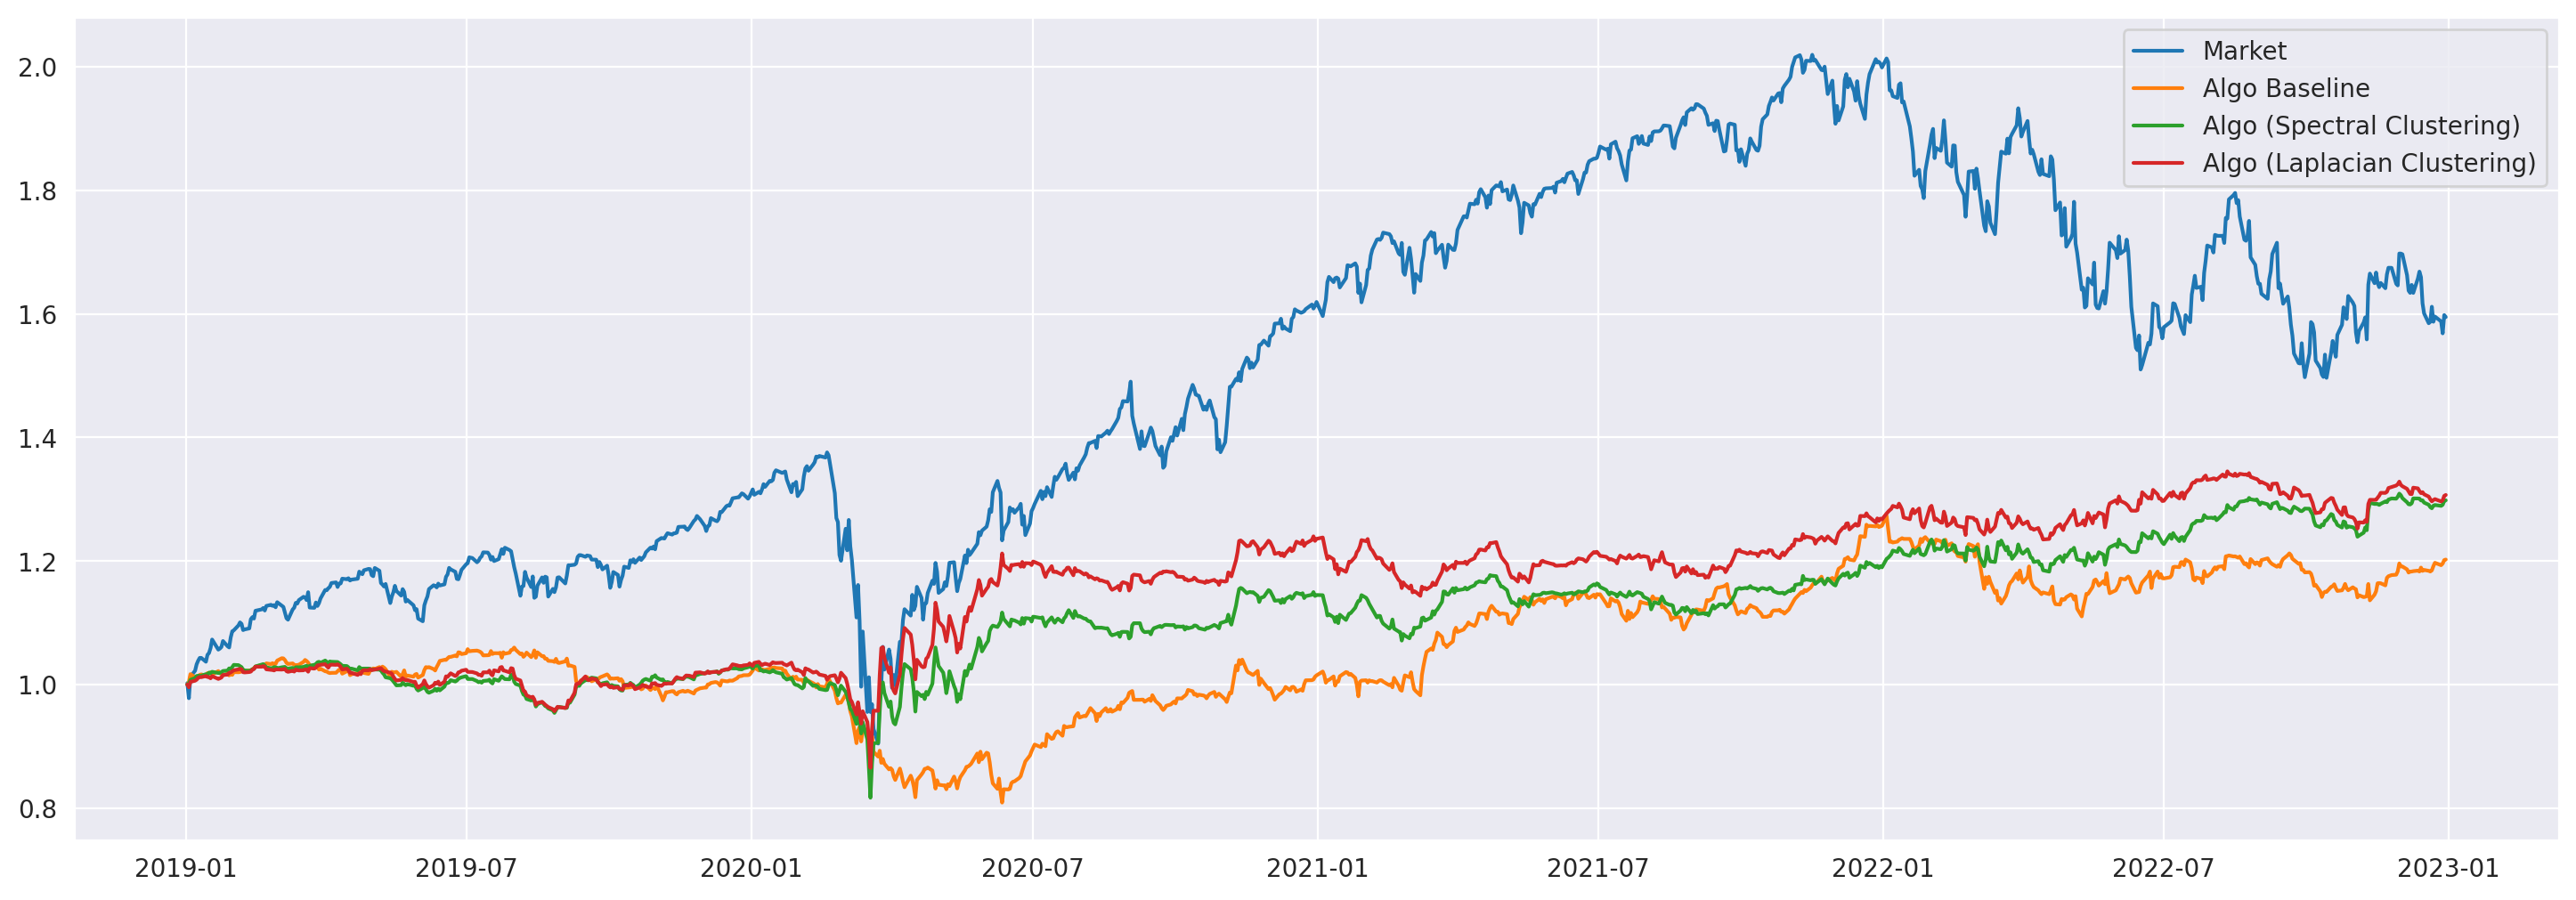

In [52]:
plt.figure(figsize=(18,6))
plt.plot(cumret_market, label='Market')
plt.plot(cumret_baseline, label='Algo Baseline')
plt.plot(cumret_spectral, label='Algo (Spectral Clustering)')
plt.plot(cumret_laplacian, label='Algo (Laplacian Clustering)')
plt.legend()

### SPONGE clustering

In [53]:
def sponge_clustering_bt(t):
    # prepare data
    returns_rf_tmp = returns_rf.loc[:t].iloc[-w:]
    returns_rf_tmp = returns_rf_tmp.dropna(axis=1)
    ff_data_tmp = ff_data.loc[returns_rf_tmp.index]

    # compute betas
    res = LinearRegression().fit(ff_data_tmp[['Mkt-RF']].values, returns_rf_tmp.values)
    betas = pd.Series(res.coef_.flatten(), index=returns_rf_tmp.columns)

    # compute residuals
    resid = pd.DataFrame(index=returns_rf_tmp.index, columns=returns_rf_tmp.columns)
    for s in resid.columns:
        resid[s] = returns_rf_tmp[s] - betas.loc[s] * ff_data_tmp['Mkt-RF']

    # estimate the number of clusters
    corr = resid.corr() # correlation matrix
    evalues = np.linalg.eigh(corr)[0]
    Q = returns_rf_tmp.shape[0] / returns_rf_tmp.shape[1]
    lambda_plus = 1 + 1/Q + 2*np.sqrt(1/Q) # upper RMT bound
    K = len(evalues[evalues>lambda_plus]) # number of clusters

    # perform clustering
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        # split adjacency matrix into positive and negative
        corr_positive = pd.DataFrame(index=corr.index, columns=corr.columns)
        corr_negative = pd.DataFrame(index=corr.index, columns=corr.columns)
        corr_positive[corr>0] = corr[corr>0]
        corr_positive = corr_positive.fillna(0)
        corr_negative[corr<0] = -corr[corr<0]
        corr_negative = corr_negative.fillna(0)
        
        c = Cluster((csc_matrix(corr_positive), csc_matrix(corr_negative)))
        ca = c.SPONGE_sym(k=K)

    # construct positions
    positions = pd.DataFrame(index=[t], columns=returns_rf.columns)
    positions = positions.fillna(0)
    for cluster in range(K):
        c_members = returns_rf_tmp.columns[ca==cluster]
        c_winners = returns_rf_tmp[c_members].mean()[returns_rf_tmp[c_members].mean()>returns_rf_tmp[c_members].mean().mean()].index
        c_losers = returns_rf_tmp[c_members].mean()[returns_rf_tmp[c_members].mean()<returns_rf_tmp[c_members].mean().mean()].index
        positions.loc[t, c_winners] = -1 / len(c_winners) # short position in winners
        positions.loc[t, c_losers] = 1 / len(c_losers) # long_position in losers

    return positions

In [54]:
positions = pd.concat([sponge_clustering_bt(t) for t in returns_rf.loc[start_date:end_date].index])

In [55]:
# make absolute values of long and short positions sum to 1
positions[positions>0] *= 1/abs(positions[positions>0].sum(axis=1)).values.reshape(-1,1)
positions[positions<0] *= 1/abs(positions[positions<0].sum(axis=1)).values.reshape(-1,1)

In [56]:
# calculate strategy returns
ret = (positions.shift() * returns.loc[positions.index]).sum(axis=1)
cumret_sponge = (1 + ret).cumprod()

In [57]:
results_df.loc['Algo SPONGE'] = calculate_metrics(cumret_sponge)

In [58]:
results_df

,Total return,APR,Sharpe,Sortino,MaxDD,MaxDDD
Market,0.591039,0.123105,0.613394,0.742505,-0.342550,282.0
Algo Baseline,0.202382,0.047154,0.438280,0.572653,-0.236759,408.0
Algo Spectral,0.298239,0.067428,0.596622,0.878711,-0.213737,271.0
Algo Laplacian,0.306932,0.069211,0.613992,0.986820,-0.165498,218.0
Algo SPONGE,0.295349,0.066834,0.710147,1.049598,-0.167572,185.0


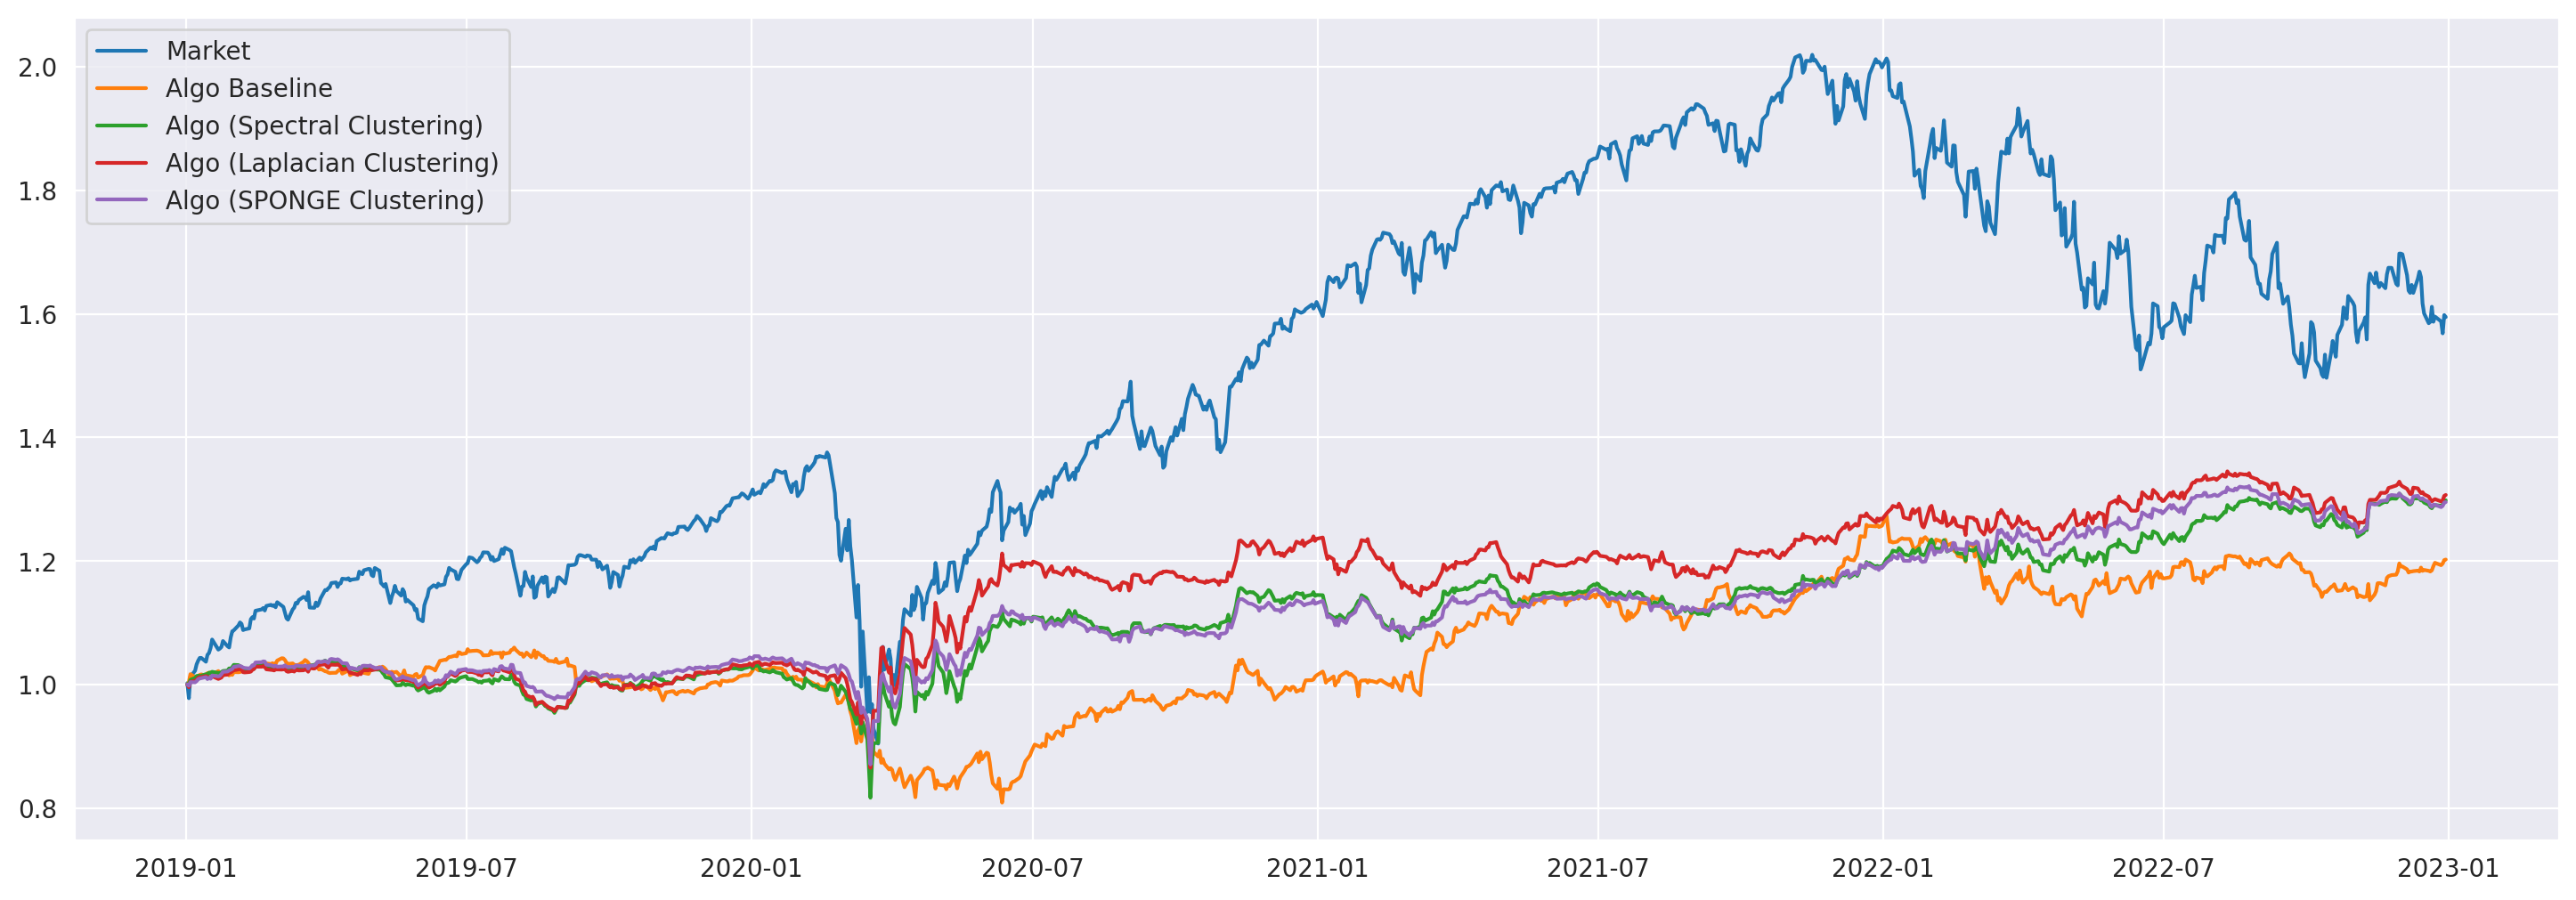

In [59]:
plt.figure(figsize=(18,6))
plt.plot(cumret_market, label='Market')
plt.plot(cumret_baseline, label='Algo Baseline')
plt.plot(cumret_spectral, label='Algo (Spectral Clustering)')
plt.plot(cumret_laplacian, label='Algo (Laplacian Clustering)')
plt.plot(cumret_sponge, label='Algo (SPONGE Clustering)')
plt.legend()

In [60]:
np.corrcoef(ret,ret_market)

array([[1.  , 0.28],
       [0.28, 1.  ]])